### CITS4404 Practical Project

# Camo Worms - Evolutionary Algorithm

In [159]:
# imports
from camo_worms_utils import *

In [200]:
def get_cost(clew: list[Camo_Worm], worm_idx: int, w_internal: float=1.0, w_group: float=1.0):
    worm = clew[worm_idx]
    # ********************
    # internal
    
    # lets just say we want worms to be around 5 px wide
    # scale so that 5px => low score, lower or higher width => high score
    ideal = 5
    dist_from_ideal = np.abs(worm.width - ideal)

    internal_score = dist_from_ideal

    # ********************
    # group

    # lets get avg dist to other worms
    dists = []
    for i in range(len(clew)):
        if i is not worm_idx:
            euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
            # print(f"Worm centre ({worm.x}, {worm.y})")
            # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
            # print(f"Dist: {euclid_dist}")
            dists.append(euclid_dist)
    avg_dist = np.mean(dists)
    inversed = 1/avg_dist

    group_score = inversed
    # ********************
    # environment

    # return total weighted
    return internal_score*w_internal + group_score*w_group*0


    

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


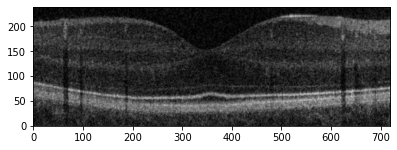

2.4347279272061093


In [201]:
# test cost
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
clew = initialise_clew(10, image.shape, (40, 30, 1))

for i in range(len(clew)):
    print(get_cost(clew=clew,worm_idx=i))
    break

In [202]:
def get_fittest(clew: list[Camo_Worm], top_percent: float=0.1):
    costs = [get_cost(clew, i) for i, worm in enumerate(clew)]
    sorted_clew = sorted(zip(clew, costs), key=lambda x: x[1])
    top_n=int(len(clew)*top_percent)
    return [worm for worm,cost in sorted_clew[:top_n]]
    

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


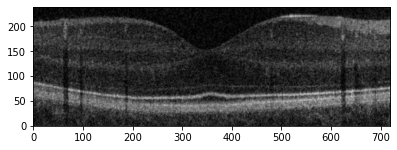

In [203]:
# test get fittest
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
clew = initialise_clew(50, image.shape, (40, 30, 1))

get_fittest(clew)

In [204]:
def mutate_worm(worm: Camo_Worm, mutation_rate: float=0.5):

    # lets say max mutation for coords is 5 percent of range
    new_x = worm.x
    if rng.random() < mutation_rate:
        # x_rnd_range = (XMAX - XMIN) * 0.05
        new_x = (worm.x + rng.uniform(-10,10))
        # take bound if new x is outside
        new_x = max( new_x, 0 )
        new_x = min( new_x, image.shape[1] )

    new_y = worm.y
    if rng.random() < mutation_rate:
        # x_rnd_range = (XMAX - XMIN) * 0.05
        new_y = (worm.y + rng.uniform(-10,10))
        # take bound if new x is outside
        new_y = max( new_y, 0 )
        new_y = min( new_y, image.shape[0] )

    new_r = worm.r
    if rng.random() < mutation_rate:
        new_r = (worm.r + rng.uniform(-1,1))

    new_theta = worm.theta
    if rng.random() < mutation_rate:
        new_theta = (worm.theta + rng.uniform(-1,1))

    new_deviation_r = worm.dr
    if rng.random() < mutation_rate:
        new_deviation_r = (worm.dr + rng.uniform(-1,1))
    
    new_deviation_gamma = worm.dgamma
    if rng.random() < mutation_rate:
        new_deviation_gamma = (worm.dgamma + rng.uniform(-1,1))
    
    new_width = worm.width
    if rng.random() < mutation_rate:
        new_width = (worm.width + rng.uniform(-1,1))
    
    new_colour = worm.colour
    if rng.random() < mutation_rate:
        new_colour = (worm.colour + rng.uniform(-1,1))
        new_colour = max( new_colour, 0 )
        new_colour = min( new_colour, 1 )

    return Camo_Worm(new_x, new_y, new_r, new_theta, new_deviation_r, new_deviation_gamma, new_width, new_colour)



def get_next_clew(fittest: list[Camo_Worm], size: int=100):
    # we will keep the parents and add new worms to size
    new_clew=fittest
    for i in range(size-len(fittest)):
        reference_worm = rng.choice(fittest)
        # mutate params
        new_worm=mutate_worm(reference_worm)
        new_clew.append(new_worm)
    return new_clew



In [205]:
# test mutate
clew = initialise_clew(50, image.shape, (40, 30, 1))
worm = clew[0]
for i in range(10):
    worm=mutate_worm(worm)

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


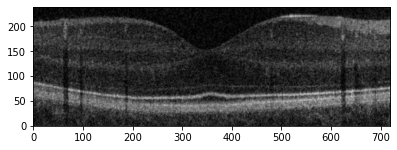

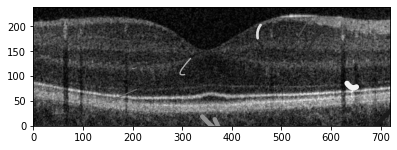

Fittest 1


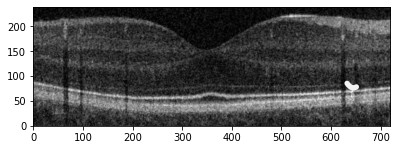

Next Clew


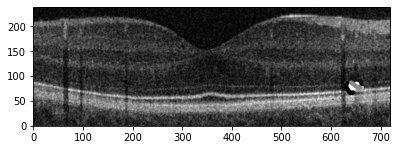

Fittest 1


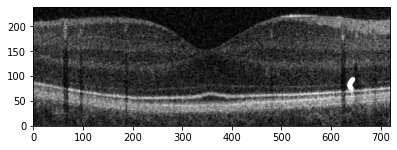

Next Clew


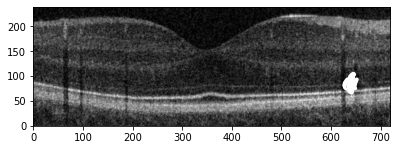

Fittest 1


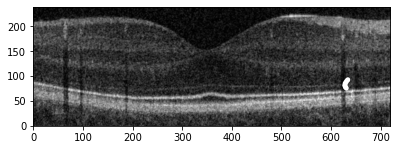

Next Clew


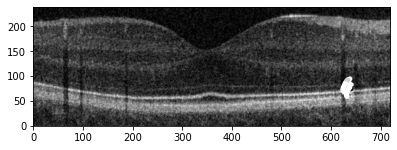

Fittest 1


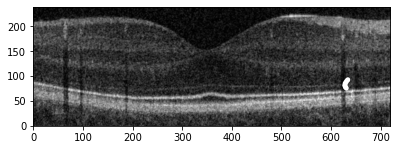

Next Clew


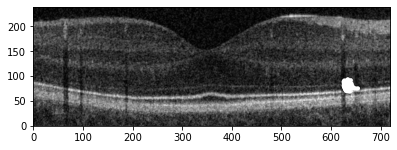

Fittest 1


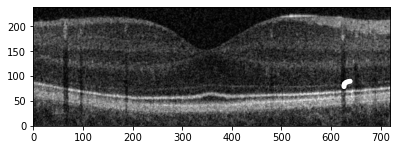

Next Clew


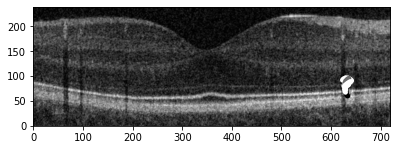

In [206]:
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
def train():
    clew = initialise_clew(10, image.shape, (40, 30, 1))

    drawing = Drawing(image)
    drawing.add_worms(clew)
    drawing.show()

    for i in range(100):
        fittest = get_fittest(clew)
        if i%20==0:
            print(f"Fittest {len(fittest)}")
            drawing = Drawing(image)
            drawing.add_worms(fittest)
            drawing.show()
        clew = get_next_clew(fittest, size=10)
        if i%20==0:
            print("Next Clew")
            drawing = Drawing(image)
            drawing.add_worms(clew)
            drawing.show()

train()

In [158]:
print(image.shape)

(240, 720)
